In [2]:
import cv2
from PIL import Image, ImageOps
import time
import os
import glob
from deepface import DeepFace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import seaborn as sns

2024-04-24 14:02:58.750539: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 14:02:58.750582: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 14:02:58.751590: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 14:02:58.844114: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
csv_directory_path = "new_tmp/"

df_VGG = pd.read_csv(csv_directory_path + "VGG-Face_comparison_results.csv")
df_Facenet = pd.read_csv(csv_directory_path + "Facenet_comparison_results.csv")
df_Facenet512 = pd.read_csv(csv_directory_path + "Facenet512_comparison_results.csv")
df_OpenFace = pd.read_csv(csv_directory_path + "OpenFace_comparison_results.csv")
df_DeepFace = pd.read_csv(csv_directory_path + "DeepFace_comparison_results.csv")
df_DeepID = pd.read_csv(csv_directory_path + "DeepID_comparison_results.csv")
df_ArcFace = pd.read_csv(csv_directory_path + "ArcFace_comparison_results.csv")
df_SFace = pd.read_csv(csv_directory_path + "SFace_comparison_results.csv")

In [4]:
dataframes = {
    "VGG-Face": df_VGG,
    "Facenet": df_Facenet,
    "Facenet512": df_Facenet512,
    "OpenFace": df_OpenFace,
    "DeepFace": df_DeepFace,
    "DeepID": df_DeepID,
    "ArcFace": df_ArcFace,
    "SFace": df_SFace
}

In [9]:
thresholds = {
     "VGG-Face": 1.17,
    "Facenet": 0.8,
    "Facenet512": 1.04,
    "OpenFace": 0.55,
    "DeepFace": 0.64,
    "DeepID": 0.17,
    "ArcFace": 1.13,
    "SFace": 1.055,
}

In [10]:
native_resolutions = {
     "VGG-Face": 224,
    "Facenet": 220,
    "Facenet512": 160,
    "OpenFace": 96,
    "DeepFace": 152,
    "DeepID": 55,
    "ArcFace": 112,
    "SFace": 112
}

In [13]:
embeddings = {
     "VGG-Face": 2622,
    "Facenet": 128,
    "Facenet512": 512,
    "OpenFace": 128,
    "DeepFace": 4096,
    "DeepID": 160,
    "ArcFace": 512,
    "SFace": 512
}

Сравнив изображения, сохранили результаты в csv. Теперь добавим новый столбец "result", в котором будет результат сравнения: TP- TN- FP- FN-

In [5]:
def calculate_result(row):

  person_1 = row['img_1'].split('_')[0]
  person_2 = row['img_2'].split('_')[0]

  if row['verified'] and person_1 == person_2:
    return 'TP'
  elif not row['verified'] and person_1 == person_2:
    return 'FN'
  elif row['verified'] and person_1 != person_2:
    return 'FP'
  elif not row['verified'] and person_1 != person_2:
    return 'TN'

In [6]:
for name, df in dataframes.items():

  df['result'] = df.apply(calculate_result, axis=1)

  df.to_csv(f'{name}_new_result.csv', index=False)

In [7]:
for name, df in dataframes.items():
  tn_count = (df['result'] == 'TN').sum()
  tp_count = (df['result'] == 'TP').sum()
  fn_count = (df['result'] == 'FN').sum()
  fp_count = (df['result'] == 'FP').sum()

  print(f"\nСтатистика для {name}:")
  print(f"Количество TN: {tn_count}")
  print(f"Количество TP: {tp_count}")
  print(f"Количество FN: {fn_count}")
  print(f"Количество FP: {fp_count}")


Статистика для VGG-Face:
Количество TN: 4624
Количество TP: 96
Количество FN: 0
Количество FP: 180

Статистика для Facenet:
Количество TN: 4804
Количество TP: 96
Количество FN: 0
Количество FP: 0

Статистика для Facenet512:
Количество TN: 4678
Количество TP: 96
Количество FN: 0
Количество FP: 126

Статистика для OpenFace:
Количество TN: 4602
Количество TP: 80
Количество FN: 16
Количество FP: 202

Статистика для DeepFace:
Количество TN: 4254
Количество TP: 82
Количество FN: 14
Количество FP: 550

Статистика для DeepID:
Количество TN: 4774
Количество TP: 82
Количество FN: 14
Количество FP: 30

Статистика для ArcFace:
Количество TN: 4778
Количество TP: 94
Количество FN: 2
Количество FP: 26

Статистика для SFace:
Количество TN: 4096
Количество TP: 90
Количество FN: 6
Количество FP: 708


*Матрицы ошибок для каждой из моделей:*

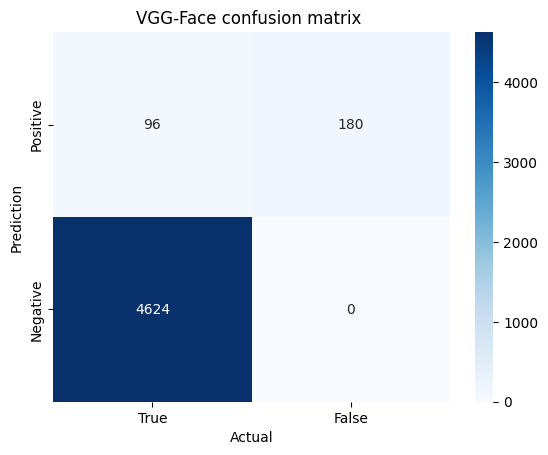

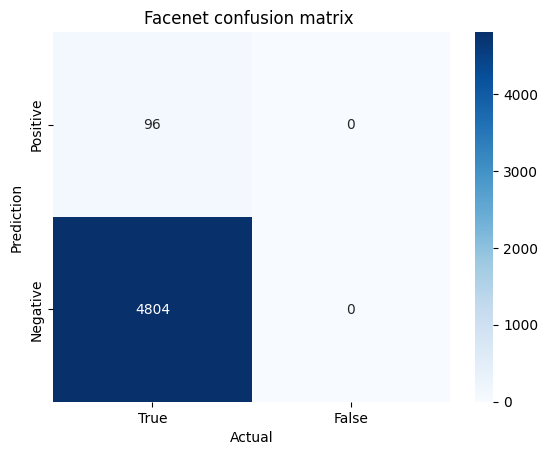

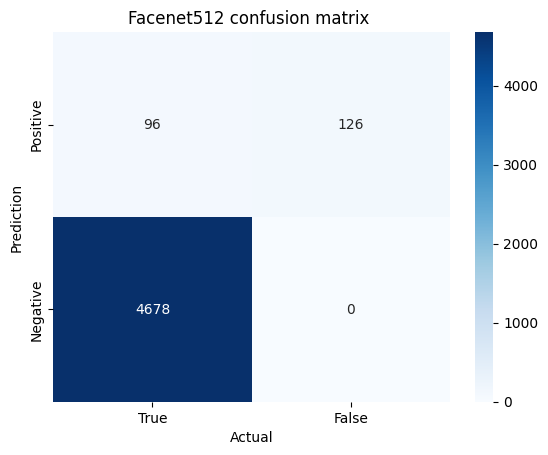

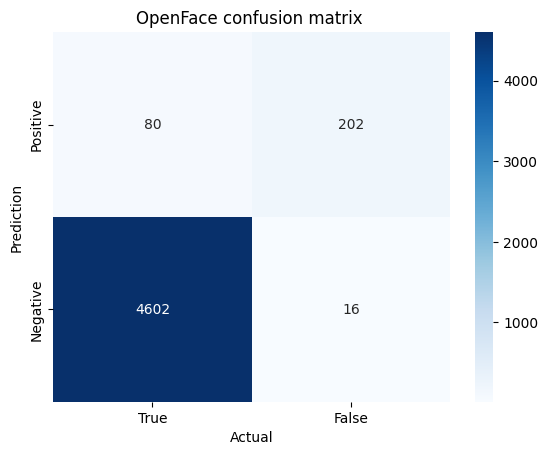

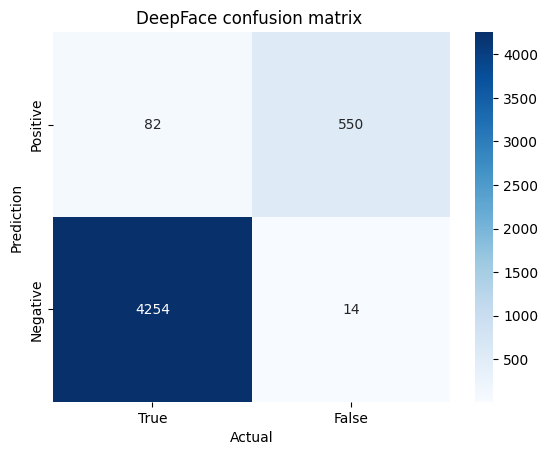

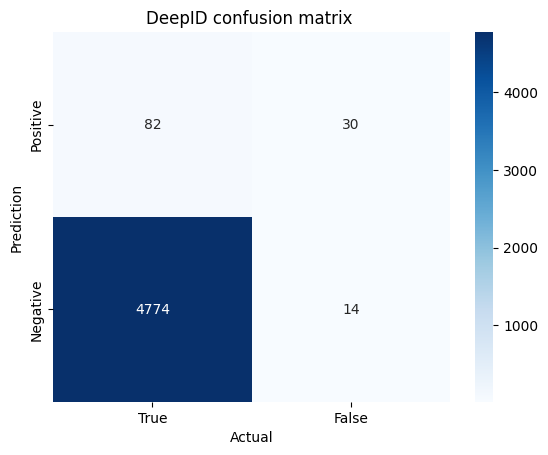

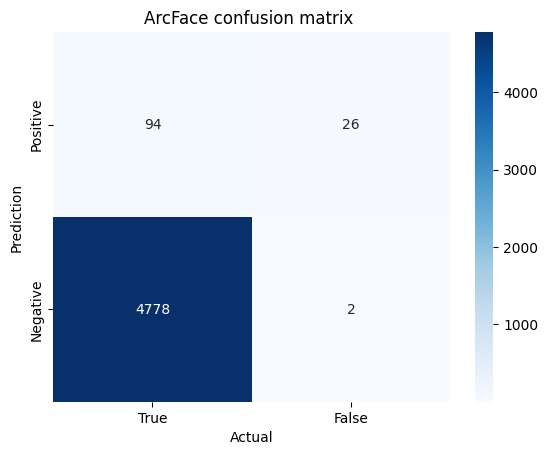

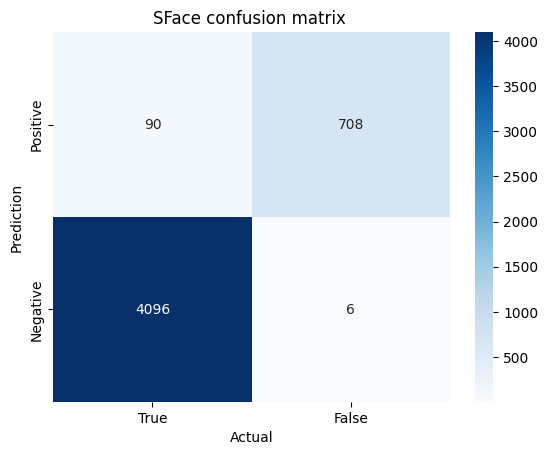

In [8]:
for model, df in dataframes.items():
  tn_count = (df['result'] == 'TN').sum()
  tp_count = (df['result'] == 'TP').sum()
  fn_count = (df['result'] == 'FN').sum()
  fp_count = (df['result'] == 'FP').sum()
  
  confusion_matrix = [[tp_count, fp_count],[tn_count, fn_count]]

  sns.heatmap(confusion_matrix, 
            annot=True,
            cmap ='Blues',
            fmt='g',
            xticklabels=['True','False'],
            yticklabels=['Positive','Negative'])

  plt.ylabel('Prediction')
  plt.xlabel('Actual')
  plt.title(f'{model} confusion matrix ')
  plt.show()

*Диаграммы рассеяния дистанций для каждого человека для каждой модели*

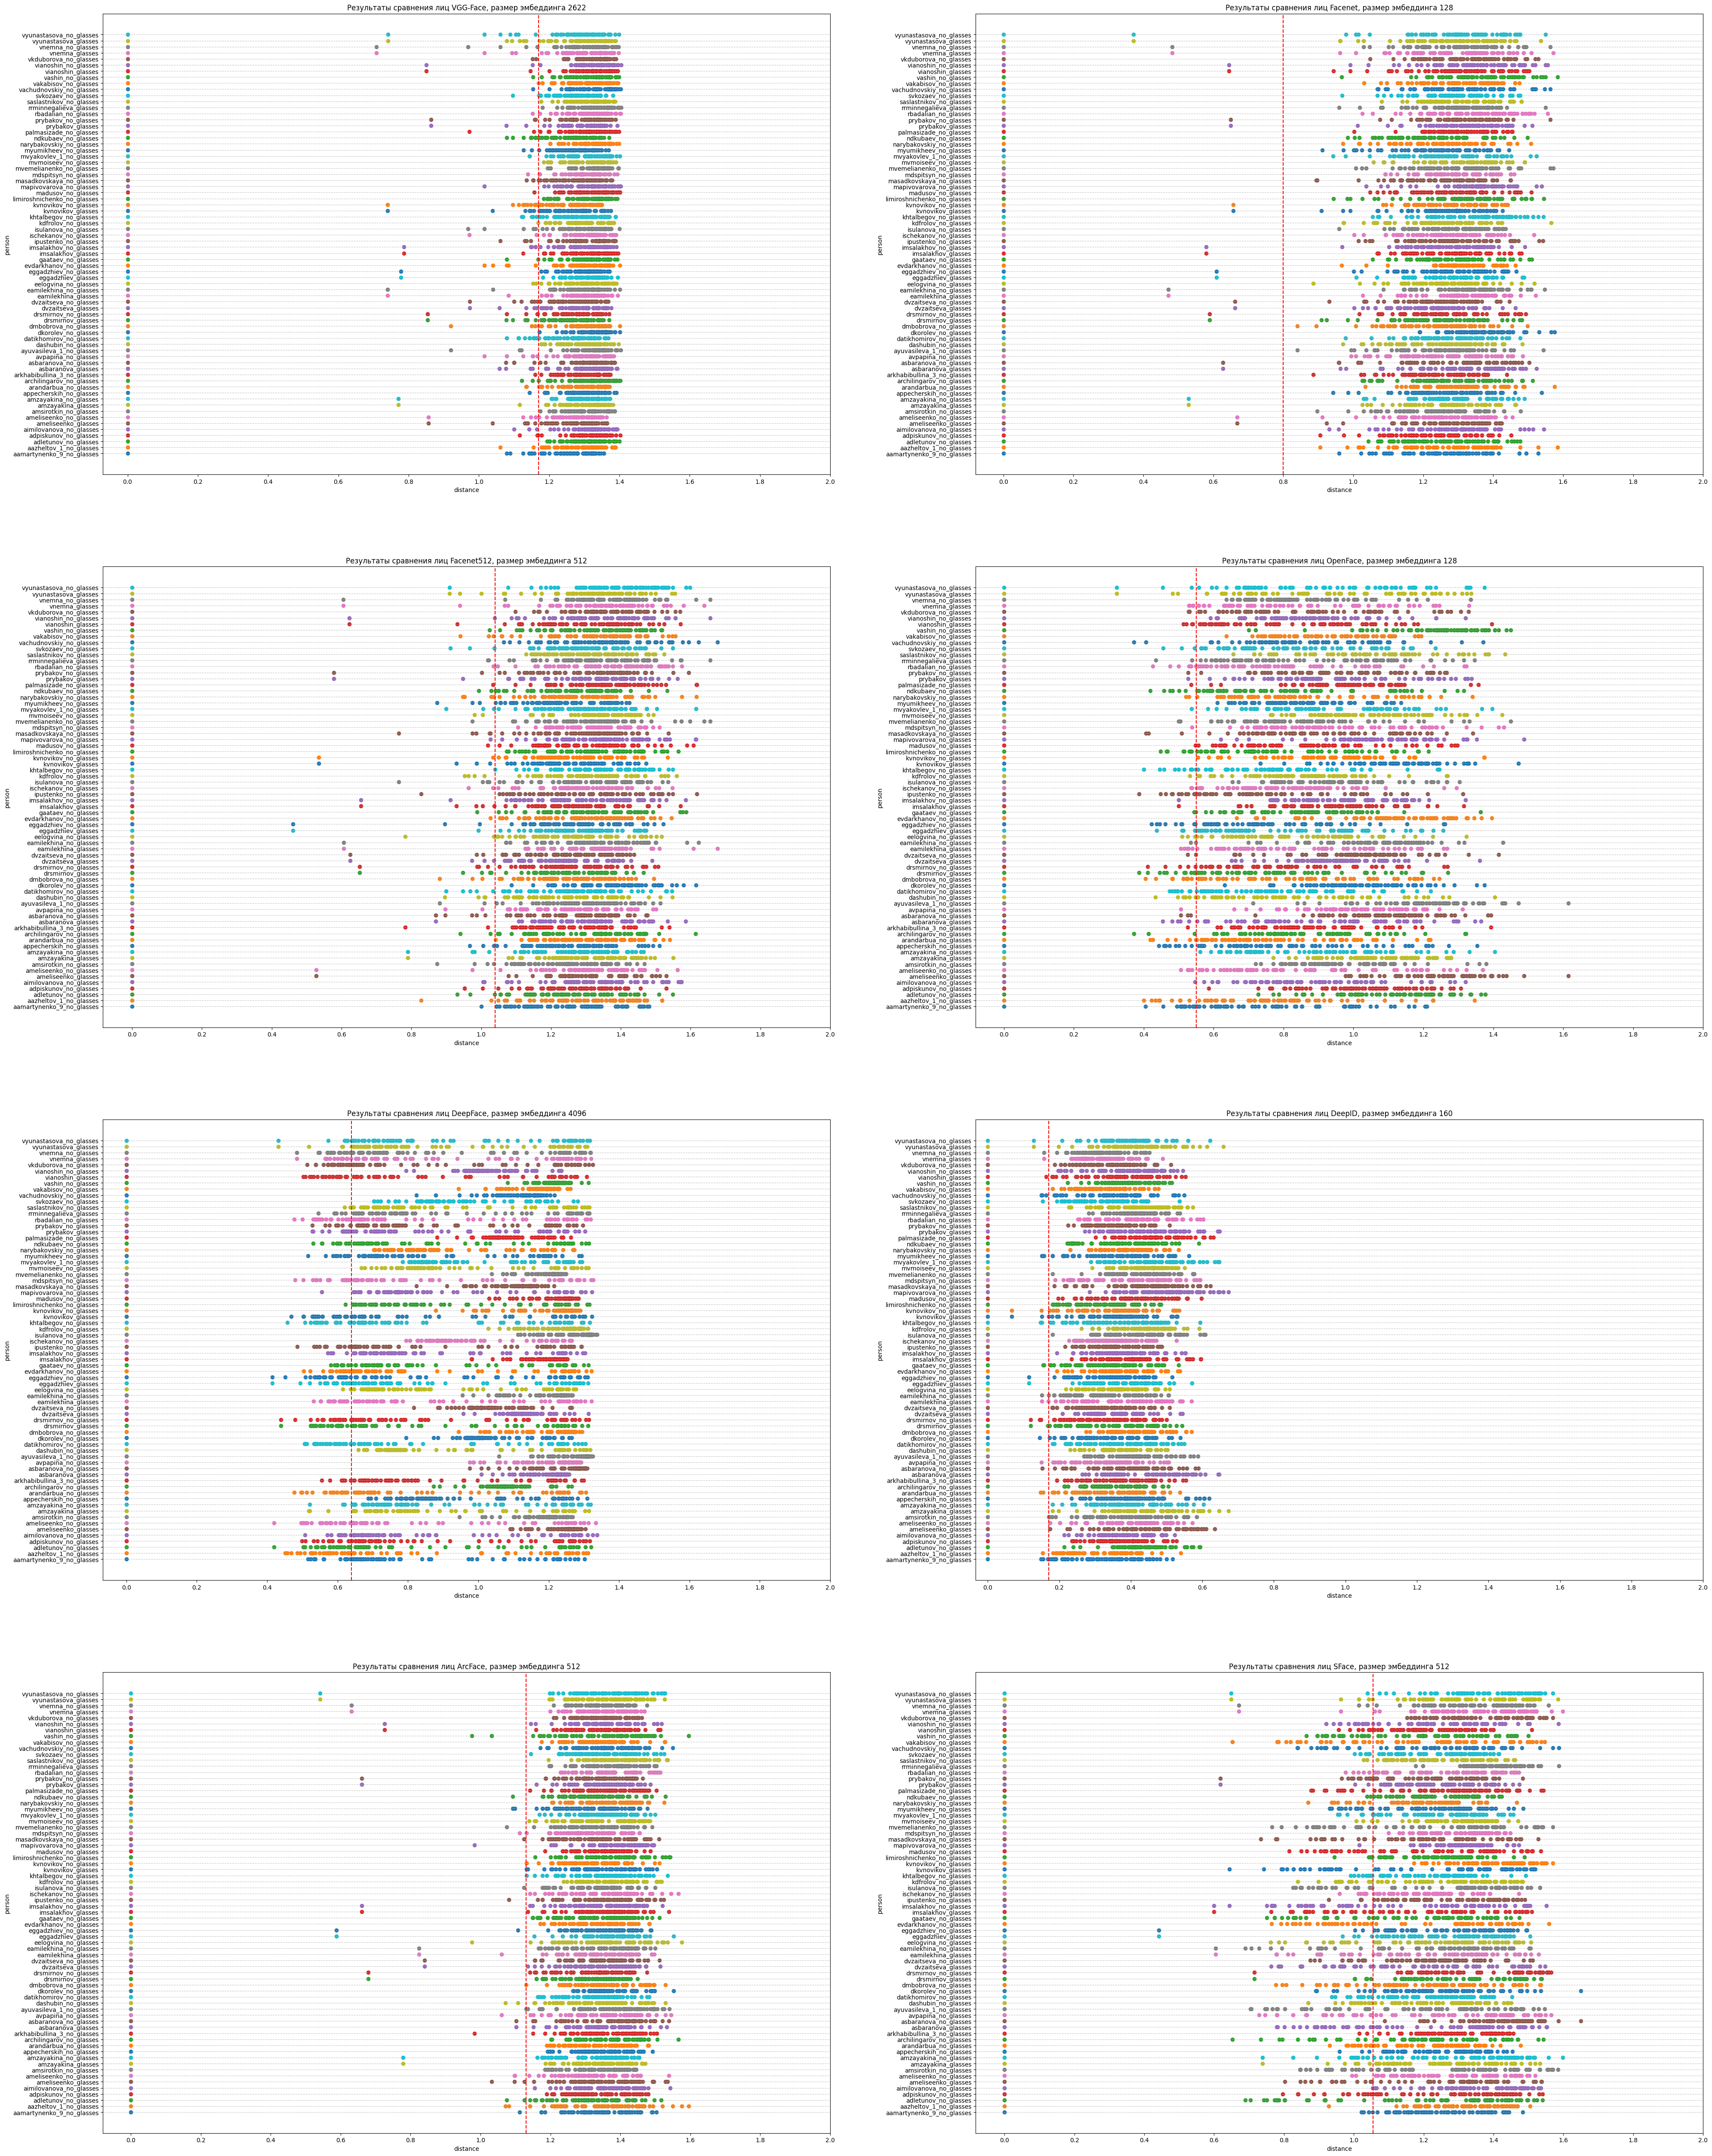

In [14]:
plt.close()
fig, axs = plt.subplots(4, 2)

counter = 0
for model, df_model in dataframes.items():
    i, j = counter // 2, counter % 2
    df_model_sorted = df_model.sort_values(by='img_1')

    uniq_people = df_model_sorted['img_1'].unique()
    fig.set_figheight(64)
    fig.set_figwidth(48)

    for person in uniq_people:
        person_data = df_model_sorted[df_model_sorted['img_1'] == person]
        axs[i,j].scatter(person_data['distance'], [person] * len(person_data), marker='o', label=person)

    axs[i, j].set_title(f'Результаты сравнения лиц {model}, размер эмбеддинга {embeddings[model]}')
    axs[i, j].set(xlabel='distance', ylabel='person', yticks = uniq_people)
    # axs[i,j].yticks(uniq_people)
    axs[i, j].grid(axis='y', linestyle='--', alpha=0.7)
    axs[i, j].axvline(x=thresholds[model], color='red', linestyle='--')
    axs[i, j].set_xticks(np.linspace(0,2,11))

    counter+=1
    
plt.show()
fig.savefig('pil_results.png')